In [3]:
import numpy as np
import os
import shutil
import time
import pinecone
from langchain.chains import ConversationalRetrievalChain, ConversationChain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers.txt import TextParser
from langchain.memory import VectorStoreRetrieverMemory
from langchain.prompts import PromptTemplate
from langchain.text_splitter import Language, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Pinecone as PineconeVectorStore
import matplotlib.pyplot as plt

Set up environment to have access to Pinecone and OpenAI

In [4]:
os.environ["OPENAI_API_KEY"] = ''
os.environ['PINECONE_API_KEY'] = ''

Initalize a pincone object

In [5]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key='5d677aa2-c09e-474f-ac6d-1aa88d19e901')

Create indexes to store our data 

In [6]:
# create an index in Pinecone storage
index_name = "testing2"

if index_name not in pc.list_indexes():
    pc.create_index(
        name=index_name,
        dimension=1536,  # Set to the dimension of OpenAI's ada-002 embeddings
        metric="euclidean", 
        spec=ServerlessSpec(
            cloud='aws', 
            region='us-east-1'
        )
    )

Data Preprocessing, generating embedding, and indexing

In [7]:
# Parse markdown documents and split them into text chunks
documentation_path = "/Users/sihamargaw/Desktop/langchain/docs"
# this loader will be used to load the .mdx files from the path
loader = GenericLoader.from_filesystem(
    documentation_path,
    glob="**/*",
    suffixes=[".mdx"],
    parser=TextParser()
)
# this splitter will be used to split the documents into size 1000 text chunks
splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN,
    chunk_size=1000,
    chunk_overlap=100
)
# load the documents using the loader created
documents = loader.load()
print(f"Number of raw documents loaded: {len(documents)}")

# split the documents using the splitter created
documents = splitter.split_documents(documents)
documents = [d for d in documents if len(d.page_content) > 5]
texts = [d.page_content for d in  documents]

# Initalize our embedding model
t1 = time.time()
embedding = OpenAIEmbeddings()

# Embedd the text chunks and store them in PineConeDB
vectorstore = PineconeVectorStore.from_documents(
    documents=documents,
    embedding=embedding,
    index_name=index_name,
    namespace="langchain-namespace"
)
t2 = time.time()
print(f"Embedd the text chunks and stored them in Pinecone DB, Total time: {(t2-t1)}s")

Number of raw documents loaded: 319
Embedd the text chunks and stored them in Pinecone DB, Total time: 48.77438020706177s


Retrieve data

In [8]:
# Initialize LLM
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0
)

# Use pinecone storage we setup as retriver in vector search
retriever = vectorstore.as_retriever()
# Use Langchain framework(ConversationalRetrievalChain a class in langchain) to make the backend for the LLM the retriver in our case it's PineCone
private_chatgpt = ConversationalRetrievalChain.from_llm(llm, retriever=retriever)

# Perform similarity search
question = "What is langchain?"

start_time = time.time() # Measure latency for retrieval
response = private_chatgpt.run({'question': question, 'chat_history': ''})
end_time = time.time()

# Calculate TileDB’s latency when retrieving data.
total_latency = end_time - start_time

print(f"User: {question}")
print(f"AI: {response}\n")
print(f"Total Latency for Retrieval: {total_latency} seconds")

User: What is langchain?
AI: LangChain is a framework for developing applications powered by large language models (LLMs). It simplifies the development, productionization, and deployment stages of LLM application lifecycle.

Total Latency for Retrieval: 1.4058938026428223 seconds


For different question formulations record time taken for retrieval

In [9]:
questions = [
    "What is LangChain?",
    "Can you explain LangChain?",
    "Describe the functionality of LangChain.",
    "What are the main features of LangChain?",
    "How does LangChain work?",
    "Can you provide an overview of LangChain?",
]

# Dictionary to store latencies for each question
latency_results_pinecone = {}

# Iterate over each question, measure latency, and store the results
for question in questions:
    print(f"Processing question: {question}")
    start_time = time.time()
    response = private_chatgpt.run({'question': question, 'chat_history': ''})
    end_time = time.time()
    latency = end_time - start_time
    latency_results_pinecone[question] = latency
    print(f"Latency for '{question}': {latency:.4f} seconds")


Processing question: What is LangChain?
Latency for 'What is LangChain?': 1.2508 seconds
Processing question: Can you explain LangChain?
Latency for 'Can you explain LangChain?': 2.1500 seconds
Processing question: Describe the functionality of LangChain.
Latency for 'Describe the functionality of LangChain.': 2.1420 seconds
Processing question: What are the main features of LangChain?
Latency for 'What are the main features of LangChain?': 1.8829 seconds
Processing question: How does LangChain work?
Latency for 'How does LangChain work?': 2.1194 seconds
Processing question: Can you provide an overview of LangChain?
Latency for 'Can you provide an overview of LangChain?': 2.4546 seconds


In [1]:
%run TileDBDiffQuestions.ipynb

Note: you may need to restart the kernel to use updated packages.


/var/folders/ym/q12h1czs7935v9b665jkynvh0000gn/T/ipykernel_13929/2032839490.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
/var/folders/ym/q12h1czs7935v9b665jkynvh0000gn/T/ipykernel_13929/2032839490.py:5: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use :meth:`~RunnableWithMessageHistory: https://python.langchain.com/v0.2/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html` instead.
  public_chatgpt = ConversationChain(llm=llm)
/Users/sihamargaw/.local/pipx/.cache/5c9468f9a0a782a/lib/python3.12/site-packages/pydantic/main.py:212: LangChainDeprecation

User: What is langchain?
AI: Langchain is a decentralized platform that aims to revolutionize the language learning industry by using blockchain technology to connect language learners with native speakers for real-time practice and feedback. It offers a wide range of language courses, personalized learning plans, and interactive exercises to help users improve their language skills. Additionally, Langchain uses smart contracts to ensure secure transactions and transparent communication between users.
Number of raw documents loaded: 319
Number of document chunks: 1358
Generating embeddings...


/var/folders/ym/q12h1czs7935v9b665jkynvh0000gn/T/ipykernel_13929/269744480.py:31: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


Embeddings generated. Total time: 7.312765836715698s
Indexing...


/Users/sihamargaw/.local/pipx/.cache/5c9468f9a0a782a/lib/python3.12/site-packages/tiledb/cloud/config.py:96: UserWarning: You must first login before you can run commands. Please run tiledb.cloud.login.
  warnings.warn(


Indexing completed. Total time: 25.334123134613037s
Number of vector embeddings stored in TileDB-Vector-Search: 1358
User: What is langchain?
AI: LangChain is a framework for developing applications powered by large language models (LLMs). It simplifies every stage of the LLM application lifecycle, including development, productionization, and deployment. LangChain provides standard, extendable interfaces and external integrations for various components useful for building with LLMs. It consists of packages like `langchain-core` and `langchain` that define core components and application architecture.

Total Latency for Retrieval: 2.10044002532959 seconds
Processing question: What is LangChain?
Latency for 'What is LangChain?': 2.3690 seconds
Processing question: Can you explain LangChain?
Latency for 'Can you explain LangChain?': 2.0264 seconds
Processing question: Describe the functionality of LangChain.
Latency for 'Describe the functionality of LangChain.': 2.7656 seconds
Processin

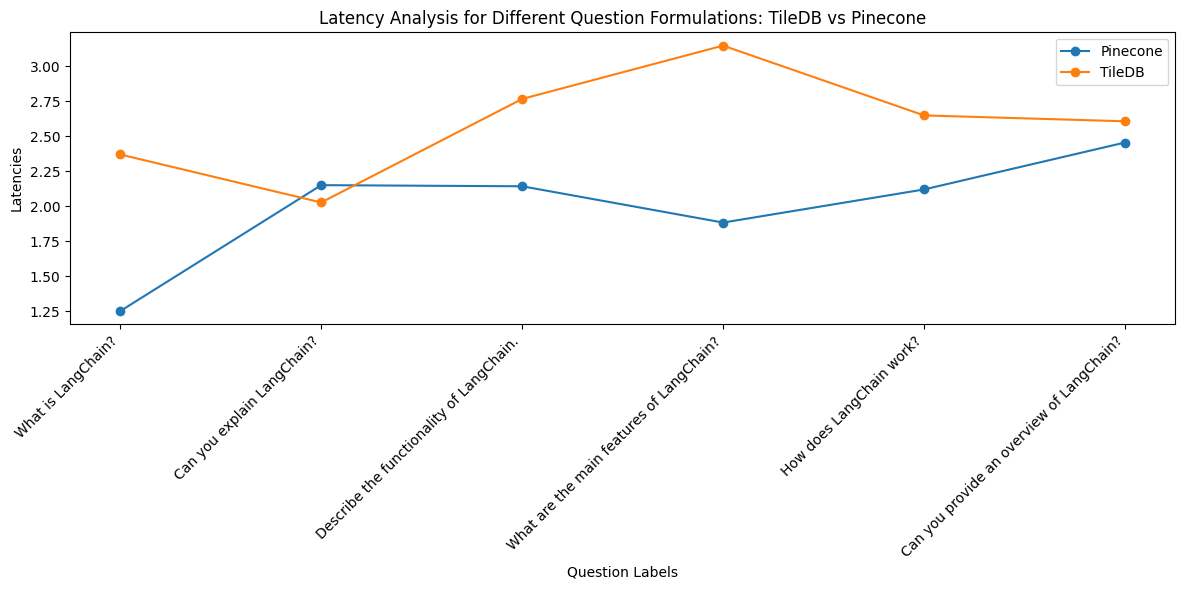

In [10]:
# Plotting the results
questions_labels = list(latency_results_pinecone.keys())
latencies_pinecone = list(latency_results_pinecone.values())
latencies_tiledb = list(latency_results_tileDB.values())

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))

# Set x positions
x = np.arange(len(questions_labels))

# Plot stacked line charts
ax.plot(x, latencies_pinecone, label='Pinecone', marker='o')
ax.plot(x, latencies_tiledb, label='TileDB', marker='o')

# Set title and labels
ax.set_title('Latency Analysis for Different Question Formulations: TileDB vs Pinecone')
ax.set_xlabel('Question Labels')
ax.set_ylabel('Latencies')

# Set xticks
ax.set_xticks(x)
ax.set_xticklabels(questions_labels, rotation=45, ha='right')

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()